# AI week 1 Liz

In [1]:
import colorama as color
import sys
sys.path.insert(0, '../')

## 1. River crossing

> ### Assignment
> As discussed in the lecture: a farmer has a wolf, a goat, and a cabbage. He must transport himself and both animals, along with the cabbage, to the other side of the river. There is a small boat in which he can carry only one thing at a time. However, if the wolf and the goat are left alone, the wolf will eat the goat. If the goat and the cabbage are left alone, the goat will eat the cabbage. 
>
> Write a Python program that provides all solutions. It can be done in less than 80 lines. You don't need to create a GUI; a simple command-line interface (CLI) is sufficient.
>
> Here are some hints: a state represents the configuration of the left and right banks. For example, 'FGCW|' is the initial state, and '|FGCW' is the final state. A state can transition to the next state as the farmer crosses the river with an item. If we view the states as nodes and the transitions as branches, we get a tree structure that we can explore with depth-first search (DFS). Refer to the lecture slides for more details.
>
> **Question: What is the time complexity of your solution?**

### Solution

Firstly, I created a class called `Node` which represents the state of the river. It has the following attributes:

- `top`: a set of characters representing items on the top side of the river. This is also the initial side.
- `bottom`: a set of characters representing items on the bottom side of the river. This is also the final side.
- `farmer`: a boolean value indicating whether the boat is on the top side or not.
- `parent`: the parent state of the current state. This is used to trace back the path from the final state to the initial state.

To be able to compare two states, I implemented the `__eq__` method. It returns `True` if the two states (top, bottom, farmer's side) are the same.

The `move` method is used to move an item from one side to the other. It takes an item as an argument and returns a new state. If the item is not on the same side as the boat, it returns `None`.

`is_valid` was somehow the hardest method to implement. It checks if the state is valid or not. A state is valid if on the side where the farmer is not,
no item is eaten. The `prohibited = [set("🐐🥬"), set("🐐🐺")]` variable contains the combinations of items that are not allowed to be on the same side.

The `get_children` method returns a list of valid states that can be reached from the current state. It does so by calling the `move` method for each item on the current side and adds this to the list **and** a child node for the farmer without any item.

In [2]:
class Node(object):
    prohibited = [set("🐐🥬"), set("🐐🐺")]

    def __init__(self, top: set[chr], bottom: set[chr], farmer: bool, parent: bool = None):
        self.top = top
        self.bottom = bottom
        self.farmer = farmer
        self.parent = parent

    def __str__(self):
        return "".join(self.top) + ("👨|" if self.farmer else "|👨") + "".join(self.bottom)

    def __eq__(self, __value: object) -> bool:
        return self.top == __value.top and self.bottom == __value.bottom and self.farmer == __value.farmer

    def move(self, item: chr):
        if self.farmer:
            self.top.remove(item)
            self.bottom.add(item)
        else:
            self.bottom.remove(item)
            self.top.add(item)
        self.farmer = not self.farmer

    def is_valid(self) -> bool:
        items_on_shore = self.bottom if self.farmer else self.top
        return  not any(p.issubset(items_on_shore) for p in self.prohibited)

    def get_children(self) -> list:
        children = []
        for item in self.top if self.farmer else self.bottom:
            child = Node(self.top.copy(), self.bottom.copy(),
                         self.farmer, self)
            child.move(item)
            children.append(child)
        child = Node(self.top.copy(), self.bottom.copy(),
                     not self.farmer, self)
        children.append(child)
        return children

#### The graph

Before implementing the algorithm, I created a graph with exalidraw to visualize the problem. The graph is shown below.

White nodes are valid nodes. Red nodes are invalid nodes. Blue nodes are duplicate nodes. The dotted blue line shows the duplicate nodes.
The green node is the final state. As you can see, there are two main branches, the `C|FWG` and `W|FCG` branches. Interestingly, both branches will converge at `G|FWC`, before reaching `FG|WC` which leads to the final state, `|FWCG`.

<div>
<img src="./graph.png" width=750"/>
</div>


#### The algorithm

##### Depth-first search
Below is the implementation of the depth-first search algorithm. It takes a node, the goal state, and a set of visited nodes as arguments (optional). The visited nodes are used during the recursive calls to prevent the algorithm from getting stuck in an infinite loop. If there is no provided, it will be initialized as an empty list.

In [3]:
def dfs(node: Node, goal: Node, visited: list = []) -> Node:
    if node == goal:
        return node
    if node in visited or not node.is_valid():
        return None
    visited.append(node)
    for child in node.get_children():
        result = dfs(child, goal, visited)
        if result is not None:
            return result
    return None

# TODO: calculate time complexity

In [4]:
def dfs(node: Node, goal: Node, visited: list = []) -> Node:
    if node == goal: # O(1) comparison
        return node # This makes the best case O(1)
    if node in visited or not node.is_valid(): # The search if the node is
        # in the visited list is O(n) and the is_valid() is (O(n * k)) where
        # k is the number of
        # prohibited sets, which is 2 in this case. So the worst case is O(2n)
        return None 
    visited.append(node) # O(1) append
    for child in node.get_children(): # O(B). B is the branching factor,
        # which is the number of children each node has.
        result = dfs(child, goal, visited) # Recursive call.
        if result is not None: # O(1) comparison
            return result # O(1) return
    return None

## Board games

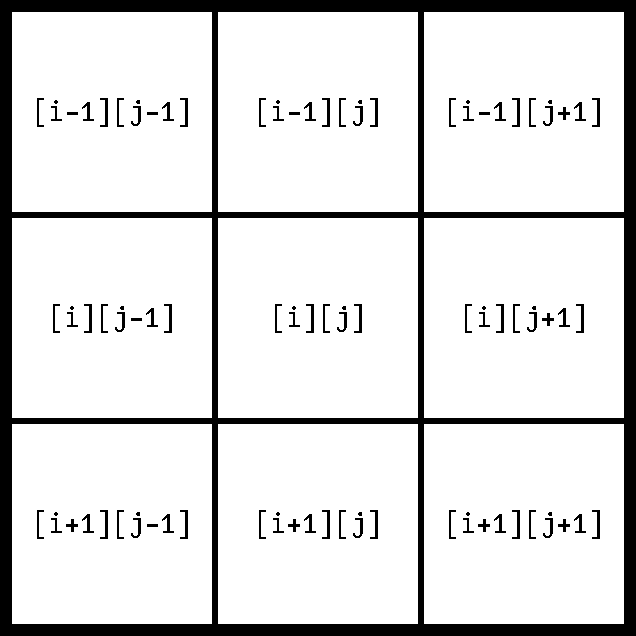

## 2. BOGGLE


> Boggle is a word game where as many words as possible must be found on an N x N board of letters. Words can be formed by creating sequences of adjacent letters. In this task, adjacency refers to horizontal or vertical connections (not diagonal), with the ability to continue from the last to the first column and from the last to the first row (and vice versa).
>
> In the 4x4 board below, for example, the words HUIS, MAT, TAS, and EI can be found:

```
┌───┬───┬───┬───┐
│ P │ I │ E │ T │
├───┼───┼───┼───┤
│ G │ A │ A │ T │
├───┼───┼───┼───┤
│ A │ T │ M │ S │
├───┼───┼───┼───┤
│ H │ U │ I │ S │
└───┴───┴───┴───┘
```


> Write a program for an NxN board, where N can vary. It can be done in fewer than 50 lines. You don't need to create a GUI; a command-line interface (CLI) based on text is sufficient.
>
> The file words.txt (available on Blackboard) contains a list of words that you can use for matching. It is useful to first create a list in memory of all possible prefixes (choose a suitable data structure for this). For example, prefixes of HUIS are H, HU, and HUI. A 'valid' state is then a sequence of letters that matches a prefix.
>
> Based on Depth-First Search (DFS), you can explore all possibilities. A path stops when the sequence of letters does not appear in the list of prefixes.
>
> Question: What is the time complexity of your solution?

In [5]:
# import the words from the file
words = []
with open("boggle/words_EN.txt") as f:
    for line in f.readlines():
        words.append(line.strip())

### Solution

In [23]:
class BoggleGame(object):
    words: set[str]
    board: list[list[chr]]
    prefixes: set[str]

    def __init__(self, words: list[str], board: list[list[chr]]):
        self.words = set(words)
        self.board = board
        self.prefixes = set()
        for word in self.words:
            for i in range(len(word)):
                self.prefixes.add(word[:i+1])

    def __str__(self):
        return "\n".join([" ".join(row) for row in self.board])

    def find_neighbors(self, i: int, j: int) -> list[tuple[int, int]]:
        neighbors = []
        for x in range(i-1, i+2):
            for y in range(j-1, j+2):
                if 0 <= x < len(self.board) and 0 <= y < len(self.board[0]) and (x, y) != (i, j):
                    neighbors.append((x, y))
        return neighbors

    def dfs(self, i: int, j: int, visited: list[tuple[int, int]], word: str) -> str:
        if (word not in self.prefixes) and (word not in self.words):
            return None
        for x, y in self.find_neighbors(i, j):
            if (x, y) not in visited:
                visited.append((x, y))
                new_word = word + self.board[x][y]
                deeper = self.dfs(x, y, visited, new_word)
                if deeper is not None:
                    return deeper
                if deeper is None and new_word in self.words:
                    return new_word
                visited.pop()
        return None

    def find_words(self) -> list[str]:
        found_words = []
        for i in range(len(self.board)):
            for j in range(len(self.board[0])):
                if (res := self.dfs(i, j, [(i, j)], self.board[i][j]))is not None:
                    found_words.append(res)
        return found_words


board = [
    ['c', 'o', 'm', 'b'],
    ['o', 'a', 'a', 's'],
    ['m', 'a', 'b', 'a'],
    ['s', 'r', 'i', 's']
]

game = BoggleGame(words, board)
f = game.find_words()

combs
oca
moco
bm
oca
acoma
amb
sma
moco
aam
bac
aam
sma
rms
iao
sb


# TODO: calculate time complexity

# TASK 3: NUMBRIX

This task resembles the previous one to some extent. Numbrix is a puzzle on an NxN board where the first number (1) and the last number (N*N) are given. A path must be found from 1 to the last number, but this path must pass along/over the given intermediate numbers ('keys' or 'clues'). In this case, the numbers must match the number of steps, so square '3' must be reached in step 3. A good Numbrix puzzle has exactly one solution. In the example below, the task is to find a route from 1 to 81, such that along the way, the given numbers are visited. The route can only go horizontally or vertically (not diagonally; this is sometimes called a Manhattan path).

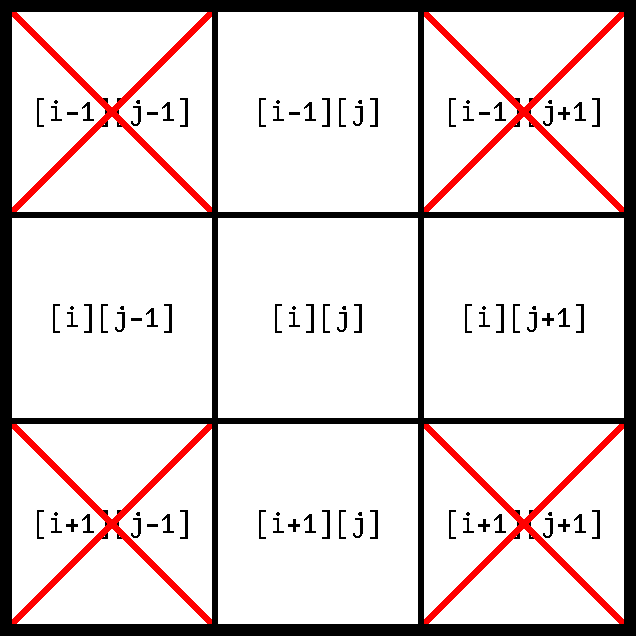

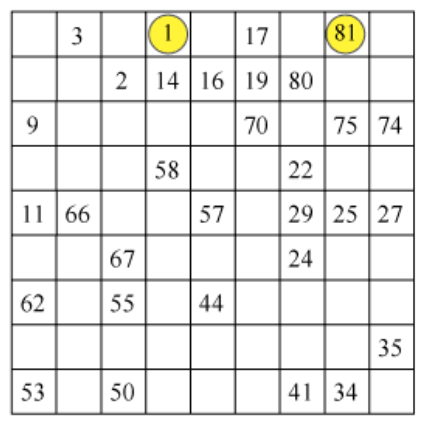

You will need the following:

• a representation of the board (or grid); consider how to easily find the neighbors of a cell and how to represent an empty cell;

• a function that returns the neighbors of a cell;

• a function that prints the board (in text) on the screen;

• a function that finds the solution (a path from 1 to NxN via the clues).


## Strategy
Using DFS, we can explore all possible paths. It is helpful to fill empty cells with a 'step counter' along the way. When backtracking, we need to adjust the values of this step counter (but not the clues!).

The challenge here is determining when a path is invalid. Visiting the same cell twice is certainly invalid. A path is also invalid when visiting a cell with a clue, and the value of the clue is not equal to that of the 'step counter'. For example, in the grids below, clue values 1, 5, and 9 are given. The first two paths are invalid, and the last path is valid.

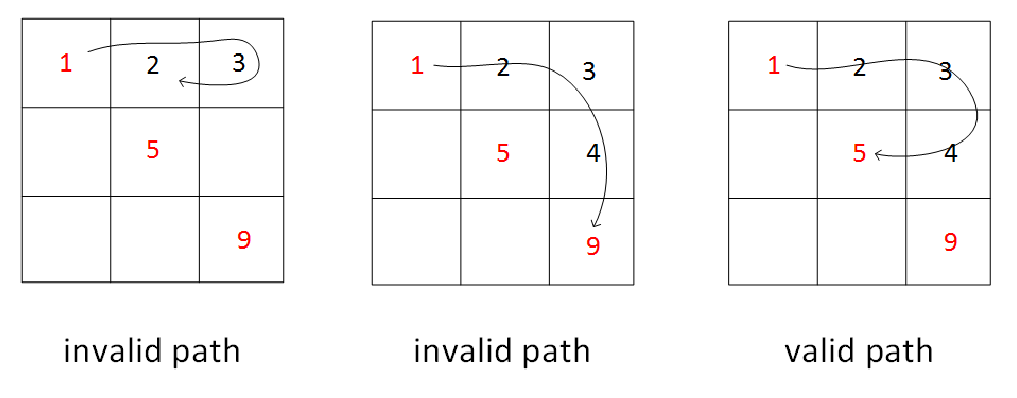

A possible algorithm based on DFS (in pseudocode) is as follows:

```python
# using DFS to traverse all paths
function solve(position, stepcount, list):
    if valid path:
        update the board and continue
    else:
        return
    if found the last clue nxn:
        # we're done, found a solution
        print(path)
        return
    for n in neighbors(position):
        # try all neighbors, increase the step count
        solve(n, stepcount+l, next_clue_in_list)
        solve(first_position, 1, next_clue_in_list)
```

Question: What is the time complexity of your solution?


In [37]:
class NumbrixBoard(object):
    def __init__(self, hints: list[list[str]]):
        self.board = hints
        self.size = len(hints)
        self.start = self.find_in_board("1")
        self.end = self.find_in_board(str(self.size**2))

    def __str__(self):
        cols = len(self.board[0])
        line = f'┌{"───┬" * (cols - 1)}───┐\n'
        separator = f'├{"───┼" * (cols - 1)}───┤\n'
        end_line = f'└{"───┴" * (cols - 1)}───┘'

        rows = [f'│ {" │ ".join(row)} │\n' for row in self.board]

        return line + separator.join(rows) + end_line

    def __repr__(self):
        return f"NumbrixBoard(hints={self.board})"

    def find_in_board(self, num: str) -> tuple[int, int] | None:
        for i in range(len(self.board)):
            for j in range(len(self.board[0])):
                if self.board[i][j] == num:
                    return (i, j)
        return None

    def get_neighbors(self, i: int, j: int) -> list[tuple[int, int]]:
        neighbors = []
        for x, y in [(i - 1, j), (i, j - 1), (i + 1, j), (i, j + 1)]:  # O(1).
            if 0 <= x < self.size and 0 <= y < self.size:
                neighbors.append((x, y))
        return neighbors

    def dfs(
        self,
        visited: list[tuple[int, int]] = [],
        num: int = 1,
        coords: tuple[int, int] = None,
        current_board: list[list[str]] = None,
    ) -> bool:
        i, j = coords or self.start
        current_board = current_board or [
            [self.board[i][j] for j in range(self.size)] for i in range(self.size)
        ]  # deep copy n^2
        for x, y in self.get_neighbors(i, j):
            if (x, y) in visited:
                continue
            if (x, y) == self.end and num == self.size**2 - 1:
                return current_board
            neigh_num = int(self.board[x][y]) if self.board[x][y] != " " else num + 1
            if (x, y) not in visited and neigh_num == num + 1:
                current_board[x][y] = str(num + 1)
                visited.append((x, y))
                if b := self.dfs(visited, num + 1, (x, y), current_board):
                    return b
                visited.pop()
        return False

    @classmethod
    def print_2d(cls, board: list[list[str]]) -> str:
        cols = len(board[0])
        line = f'┌{"───┬" * (cols - 1)}───┐\n'
        separator = f'├{"───┼" * (cols - 1)}───┤\n'
        end_line = f'└{"───┴" * (cols - 1)}───┘'

        rows = [f'│ {" │ ".join(row)} │\n' for row in board]
        if board[2][1] == "8":
            print("here")
        print(line + separator.join(rows) + end_line)


b = NumbrixBoard([["1", " ", " "], [" ", "5", " "], [" ", " ", "9"]])

print(NumbrixBoard.print_2d(b.dfs()))


┌───┬───┬───┐
│ 1 │ 6 │ 7 │
├───┼───┼───┤
│ 2 │ 5 │ 8 │
├───┼───┼───┤
│ 3 │ 4 │ 9 │
└───┴───┴───┘
None
